# Import Libraries

In [1]:
#import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import euclidean

In [2]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  import sys
  path_to_project = '/content/drive/MyDrive/FairAlgorithm'
  sys.path.append(path_to_project)
  !sudo apt install libcairo2-dev pkg-config python3-dev
  IN_COLAB = True
except:
  IN_COLAB = False

Mounted at /content/drive
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-dev is already the newest version (3.10.6-1~22.04.1).
python3-dev set to manually installed.
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libblkid-dev libblkid1 libcairo-script-interpreter2 libffi-dev
  libglib2.0-dev libglib2.0-dev-bin libice-dev liblzo2-2 libmount-dev
  libmount1 libpixman-1-dev libselinux1-dev libsepol-dev libsm-dev
  libxcb-render0-dev libxcb-shm0-dev
Suggested packages:
  libcairo2-doc libgirepository1.0-dev libglib2.0-doc libgdk-pixbuf2.0-bin
  | libgdk-pixbuf2.0-dev libxml2-utils libice-doc cryptsetup-bin libsm-doc
The following packages will be REMOVED:
  pkgconf r-base-dev
The following NEW packages will be installed:
  libblkid-dev libcairo-script-interpreter2 

# Load Fairness Metrics

In [3]:
# Load the metrics results
def load_metrics(dataset_name, mitigation):
  load_path = path_to_project + '/measurements/metrics-{}-{}.p'.format(dataset_name, mitigation)
  with open(load_path, 'rb') as fp:
      mitigation_metrics = pickle.load(fp)
  return mitigation_metrics

In [5]:
m= load_metrics("diabetes-women", "aif360-ad")
print(m)
print(m['division']['GroupFairness'][0])

{'division': {'GroupFairness': [-0.6264614667511951, 0.1456682493056292], 'PredictiveParity': [-0.31069597069597066, 0.7700699033725338], 'PredictiveEquality': [-0.5380272651325283, 0.47221560389076145], 'EqualOpportunity': [-0.37214285714285716, 0.5146978617488991], 'EqualizedOdds': [0.8587912087912087, 0.25743444067377363], 'ConditionalUseAccuracyEquality': [0.823181818181818, 0.2025299692138229], 'OverallAccuracyEquality': [0.3598879551820728, 0.7555131454755576], 'TreatmentEquality': [-0.11944444444444444, 0.8117624857883822], 'FORParity': [0.531275, 0.7895746517112869], 'FN': [0.739175925925926, 0.3768755167062363], 'FP': [-0.33762126891951455, 0.6238932542256409]}, 'subtraction': {'GroupFairness': [0.22400206219400162, 0.07493312286722108], 'PredictiveParity': [-0.5922282980177717, 0.44874224067972135], 'PredictiveEquality': [-0.0916210032657401, 0.4670960195051952], 'EqualOpportunity': [-0.43755952380952384, 0.3796421338597539], 'EqualizedOdds': [-0.06782525953578586, 0.25348554

In [45]:
dataset_list = ["diabetes-women"] # TO DO: add other datasets
mitigation_list = ['original', 'fl-cr', 'fl-to', 'aif360-rw', 'aif360-di', 'aif360-lfr', 'aif360-op', 'aif360-ad', 'aif360-pr', 'aif360-er', 'aif360-ce', 'aif360-eo', 'aif360-roc']

preprocessing_mitigation_list = ['fl-cr', 'aif360-rw', 'aif360-di', 'aif360-lfr']
inprocessing_mitigation_list = ["aif360-ad", "aif360-er", "aif360-pr"]
postprocessing_mitigation_list = ['aif360-roc', 'aif360-ce', 'aif360-eo']
without_model_mitigations = ['aif360-ad', 'aif360-pr', 'aif360-er']
new_dataset_mitigations = ["fl-cr", "aif360-di", "aif360-op" "aif360-lfr"]

comparison = ['division', 'subtraction']
models = ['Logistic Regression', 'Decision Tree', 'Bagging', 'Random Forest', 'Extremely Randomized Trees', 'Ada Boost']
metrics = ['GroupFairness', 'PredictiveParity', 'PredictiveEquality', 'EqualOpportunity', 'EqualizedOdds', 'ConditionalUseAccuracyEquality', 'OverallAccuracyEquality', 'TreatmentEquality', 'FORParity', 'FN', 'FP']

In [14]:
overall_metrics = {}
preprocessing_metrics = {}
inprocessing_metrics = {}
postprocessing_metrics = {}

# Load metrics for all datasets and mitigations
for dataset in dataset_list:
  ds_metrics = {}
  pre_metrics = {}
  in_metrics = {}
  post_metrics = {}
  for mitigation in mitigation_list:
    ds_metrics[mitigation] = load_metrics(dataset, mitigation)
  for mitigation in preprocessing_mitigation_list:
    pre_metrics[mitigation] = load_metrics(dataset, mitigation)
  for mitigation in inprocessing_mitigation_list:
    in_metrics[mitigation] = load_metrics(dataset, mitigation)
  for mitigation in postprocessing_mitigation_list:
    post_metrics[mitigation] = load_metrics(dataset, mitigation)
  overall_metrics[dataset] = ds_metrics
  preprocessing_metrics[dataset] = pre_metrics
  inprocessing_metrics[dataset] = in_metrics
  postprocessing_metrics[dataset] = post_metrics


In [18]:
# Load original measurements for each dataset and add to dictionary
for dataset in dataset_list:
  original_metrics = {}
  load_path = path_to_project + '/measurements/metrics-{}-original.p'.format("diabetes-women")
  with open(load_path, 'rb') as fp:
      original_metrics = pickle.load(fp)
  overall_metrics[dataset]['original'] = original_metrics
  preprocessing_metrics[dataset]['original'] = original_metrics
  postprocessing_metrics[dataset]['original'] = original_metrics
  for m in models:
    orig_metrics = {}
    orig_metrics['division'] = original_metrics['division'][m]
    orig_metrics['subtraction'] = original_metrics['subtraction'][m]
    inprocessing_metrics[dataset]['orig-'+str(m)] = orig_metrics
    #inprocessing_metrics[dataset][m]['division'] = original_metrics['division'][m]
    #inprocessing_metrics[dataset][m]['subtraction'] = original_metrics['subtraction'][m]

  postprocessing_metrics[dataset]['original'] = original_metrics

# Plotting Metrics

## Plotting functions
Grouped bar chart with full results for one mitigation.

In [20]:
def grouped_bar(metrics_dict, mitigation_list, comparison, model):
  bars_per_group = len(metrics)
  num_groups = len(mitigation_list)

  data = []
  for mitigation in mitigation_list:
    l = []
    for metric in metrics:
      l.append(metrics_dict[mitigation][comparison][model][metric][0])
    data.append(l)

  data = np.asarray(data)
  data = data.reshape((num_groups, bars_per_group))

  # Set up bar positions
  bar_width = 0.1
  bar_positions = np.arange(bars_per_group)

  plt.figure(figsize=(12, 6))

  # Plot the vertical bar plot
  for i in range(num_groups):
      plt.bar(bar_positions + i*bar_width,
              data[i],
              width=bar_width,
              label=mitigation_list[i])

  # Add labels and title
  plt.xlabel('Bar Group')
  plt.ylabel('Values')
  plt.title('Vertical Bar Plot')

  plt.xticks(bar_positions + bar_width, metrics, rotation=45, ha='right')
  plt.legend()

  # Show the plot
  plt.show()

In [21]:
def grouped_bar_no_model(metrics_dict, mitigation_list, comparison):
  bars_per_group = len(metrics)
  num_groups = len(mitigation_list)

  data = []
  for mitigation in mitigation_list:
    l = []
    for metric in metrics:
      l.append(metrics_dict[mitigation][comparison][metric][0])
    data.append(l)

  data = np.asarray(data)
  data = data.reshape((num_groups, bars_per_group))

  # Set up bar positions
  bar_width = 0.1
  bar_positions = np.arange(bars_per_group)

  plt.figure(figsize=(12, 6))

  # Plot the vertical bar plot
  for i in range(num_groups):
      plt.bar(bar_positions + i*bar_width,
              data[i],
              width=bar_width,
              label=mitigation_list[i])

  # Add labels and title
  plt.xlabel('Bar Group')
  plt.ylabel('Values')
  plt.title('Vertical Bar Plot')

  plt.xticks(bar_positions + bar_width, metrics, rotation=45, ha='right')
  plt.legend()

  # Show the plot
  plt.show()

## Preprocessing results

In [28]:
preprocessing_mitigation_list.insert(0,'original')

### Diabetes-women, all pre-processing techniques, division, all ML models

Logistic Regression


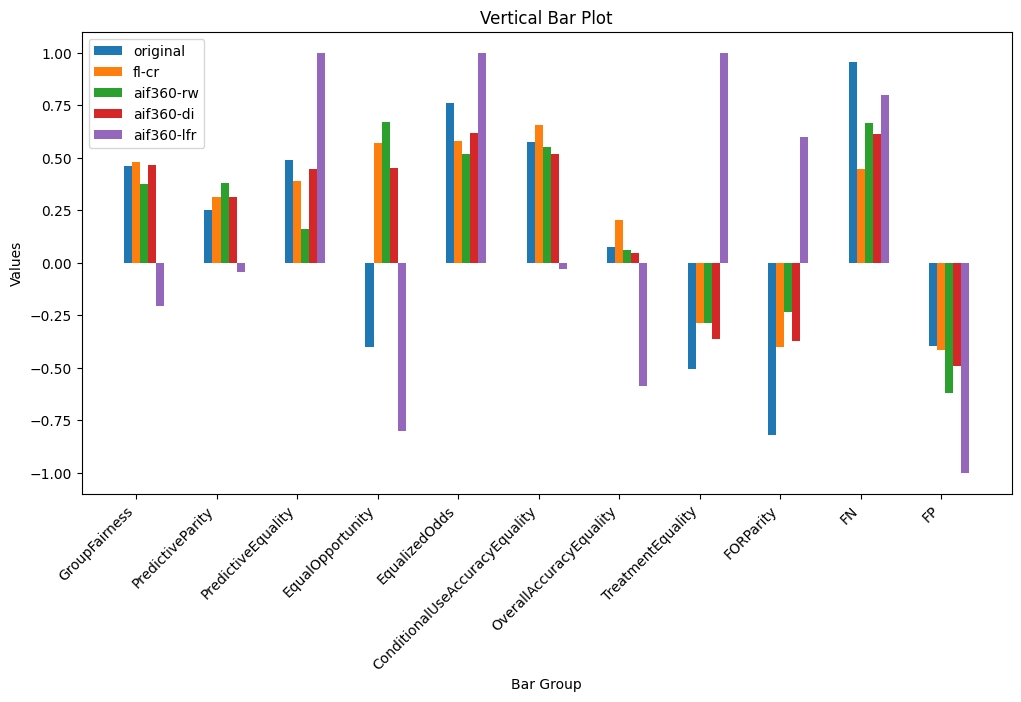

Decision Tree


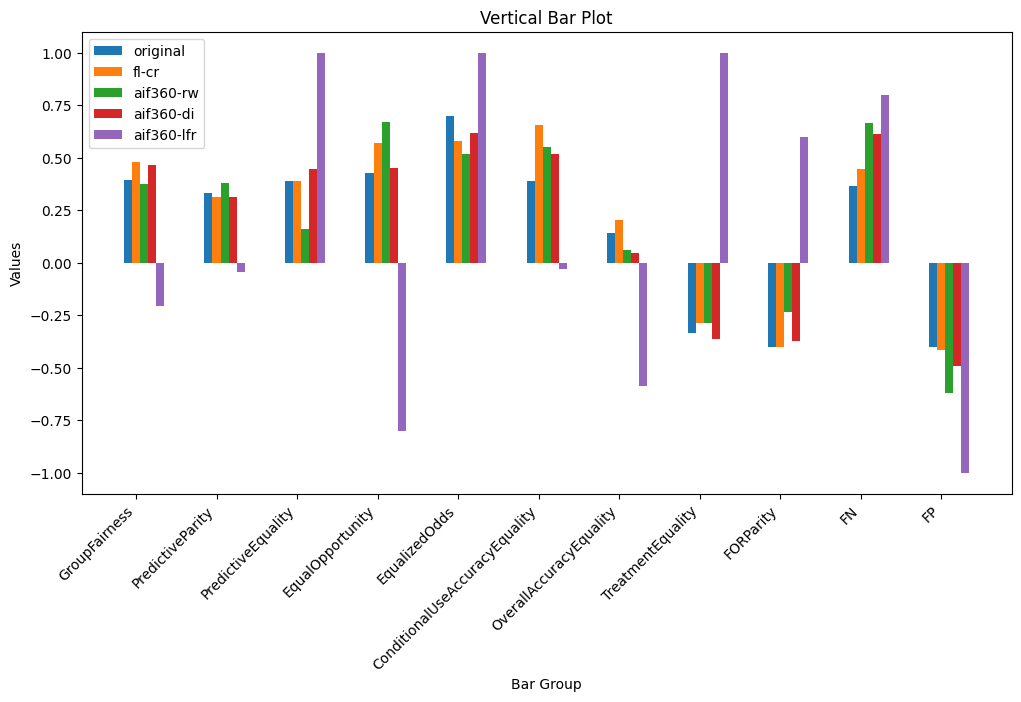

Bagging


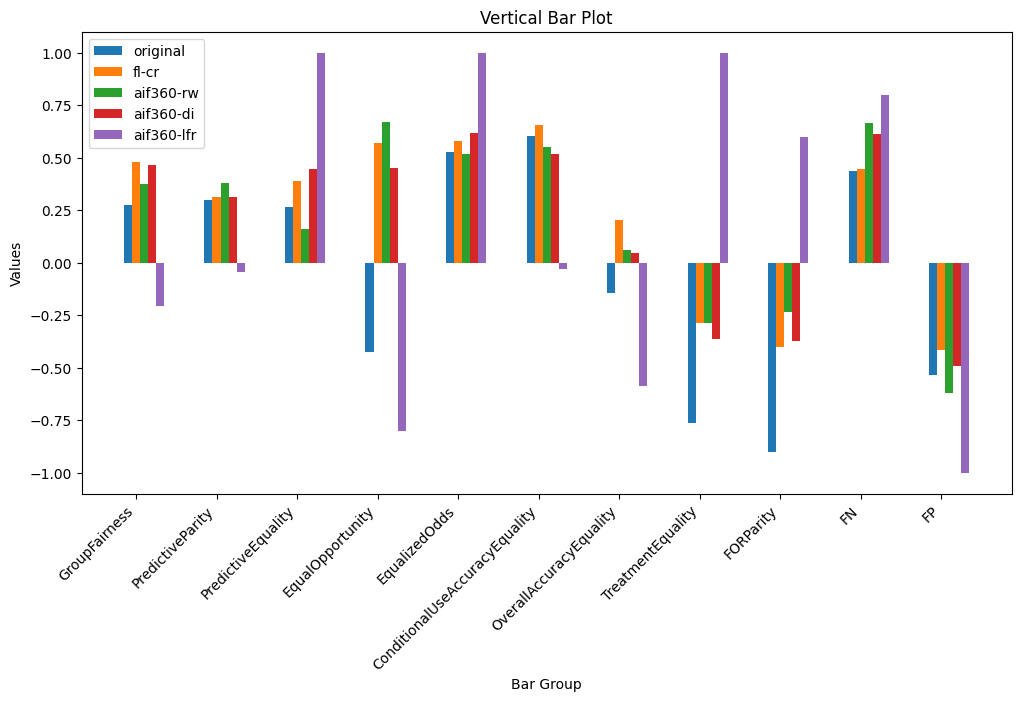

Random Forest


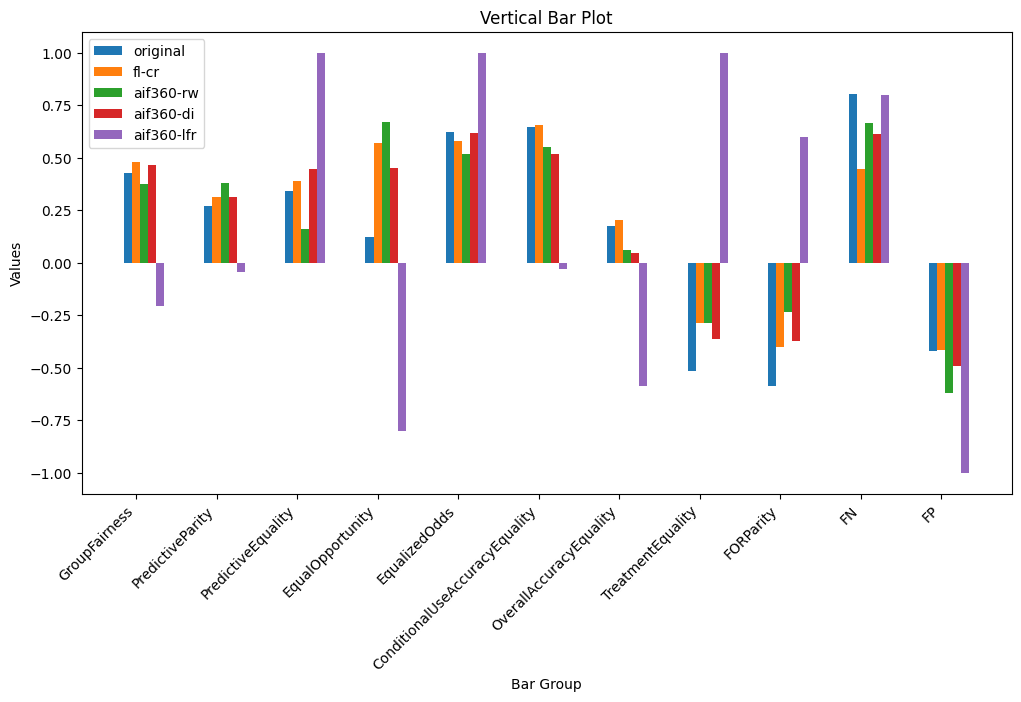

Extremely Randomized Trees


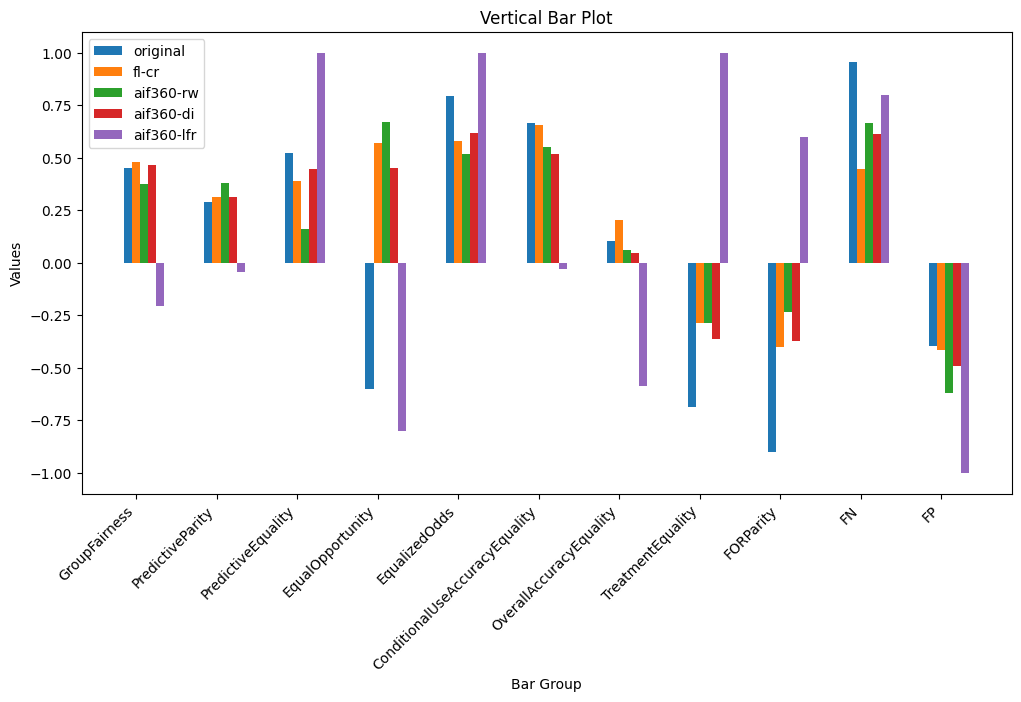

Ada Boost


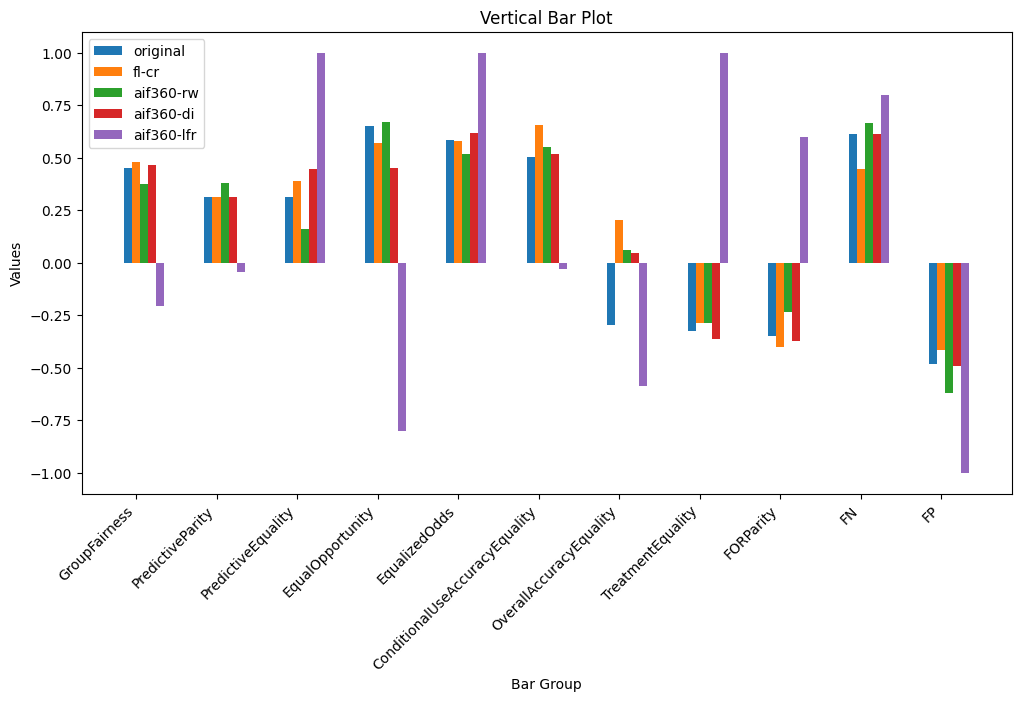

In [29]:
for m in models:
  print(m)
  grouped_bar(preprocessing_metrics["diabetes-women"], preprocessing_mitigation_list, "division", m)

### Diabetes-women, all pre-processing techniques, subtraction, all ML models

Logistic Regression


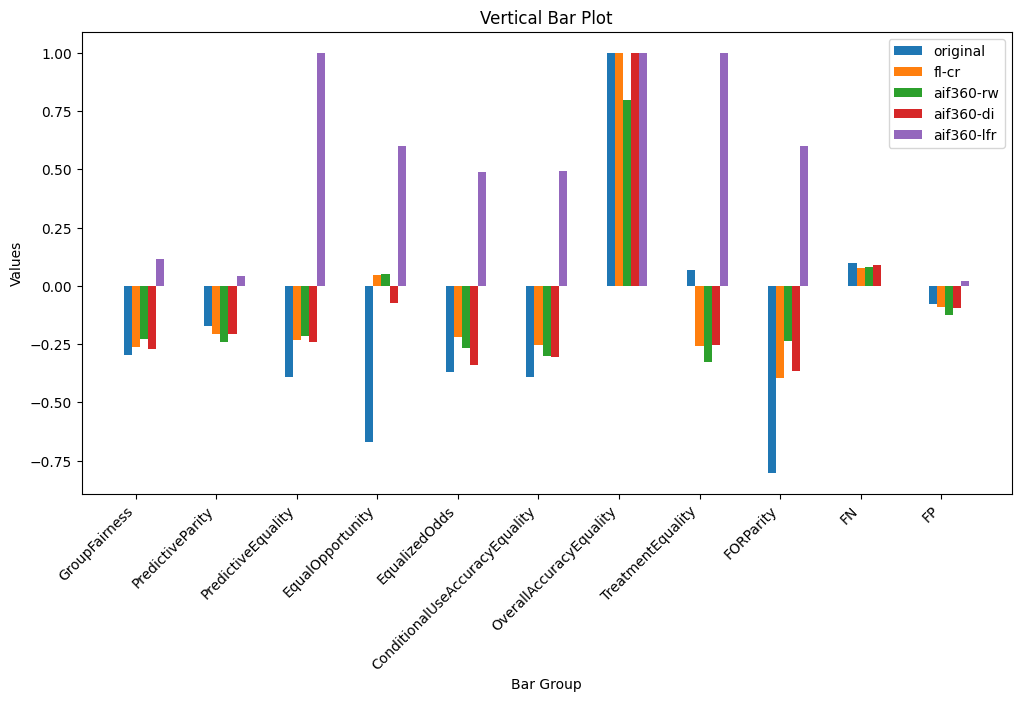

Decision Tree


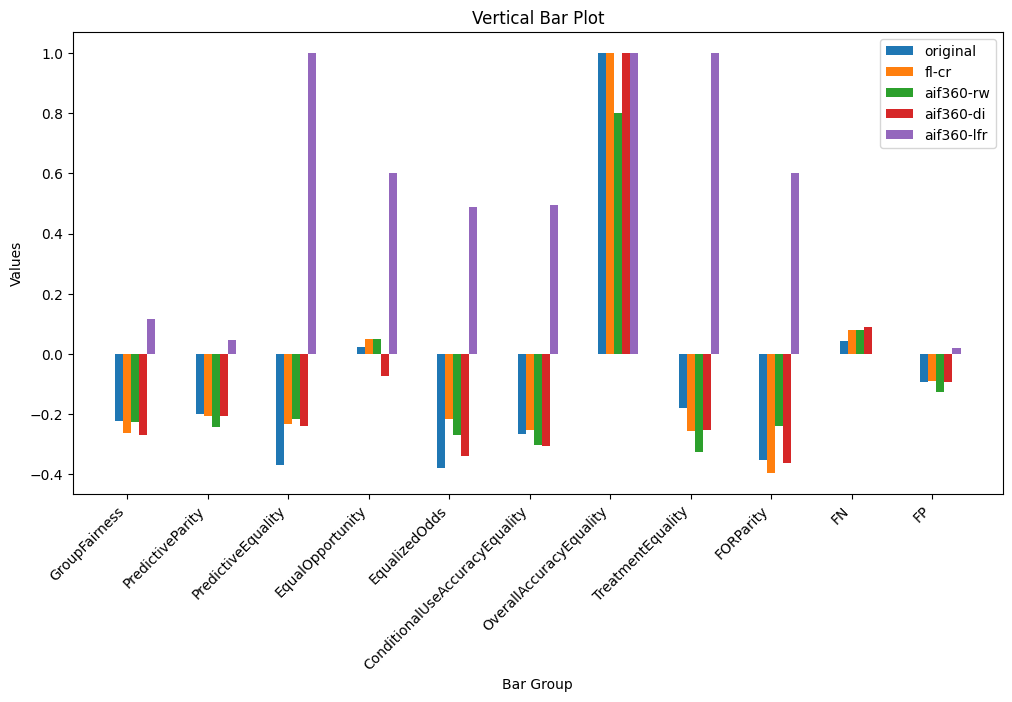

Bagging


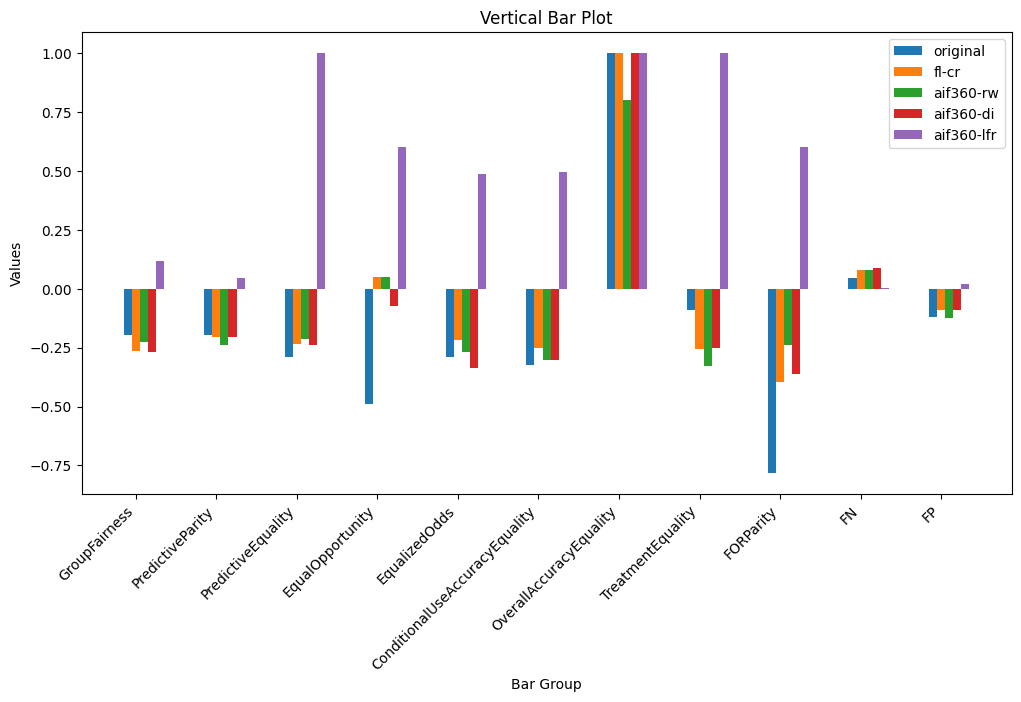

Random Forest


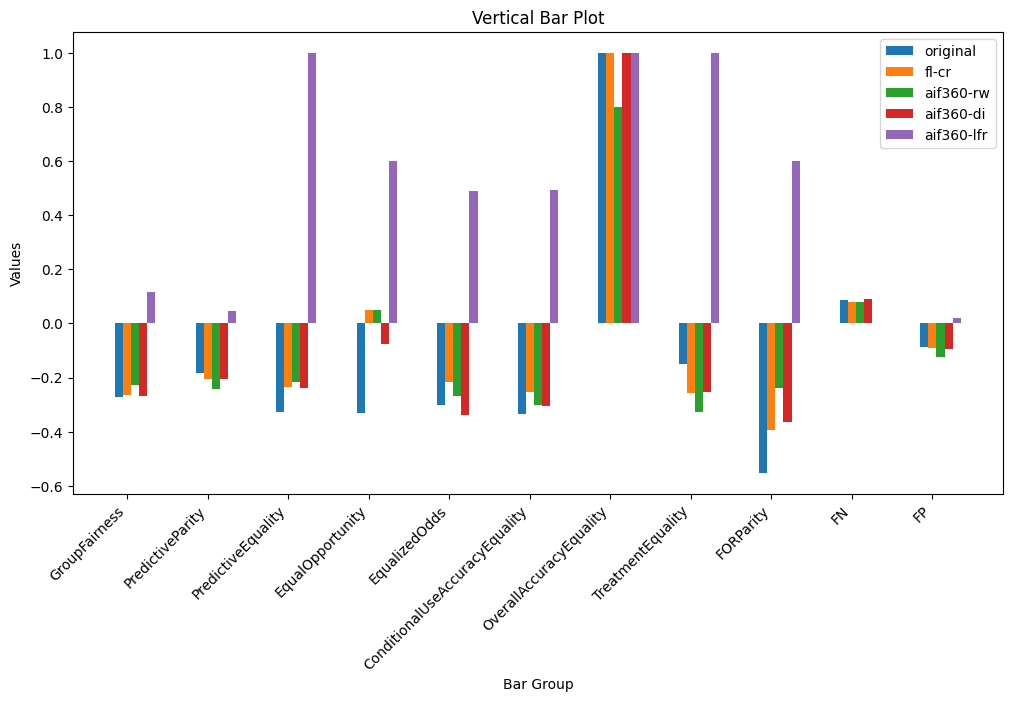

Extremely Randomized Trees


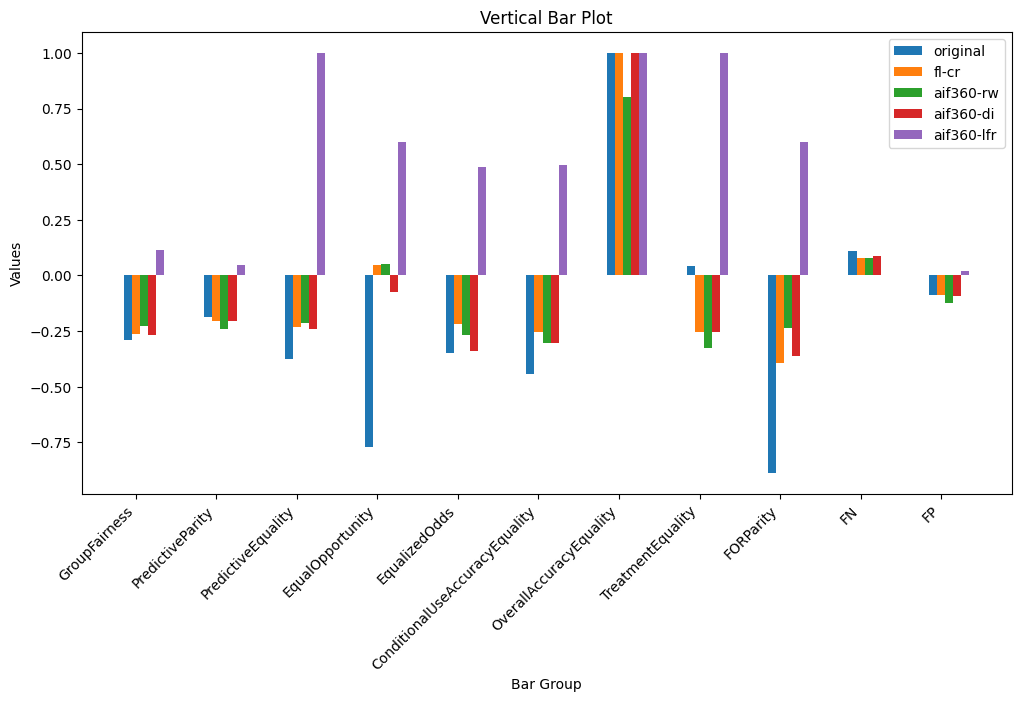

Ada Boost


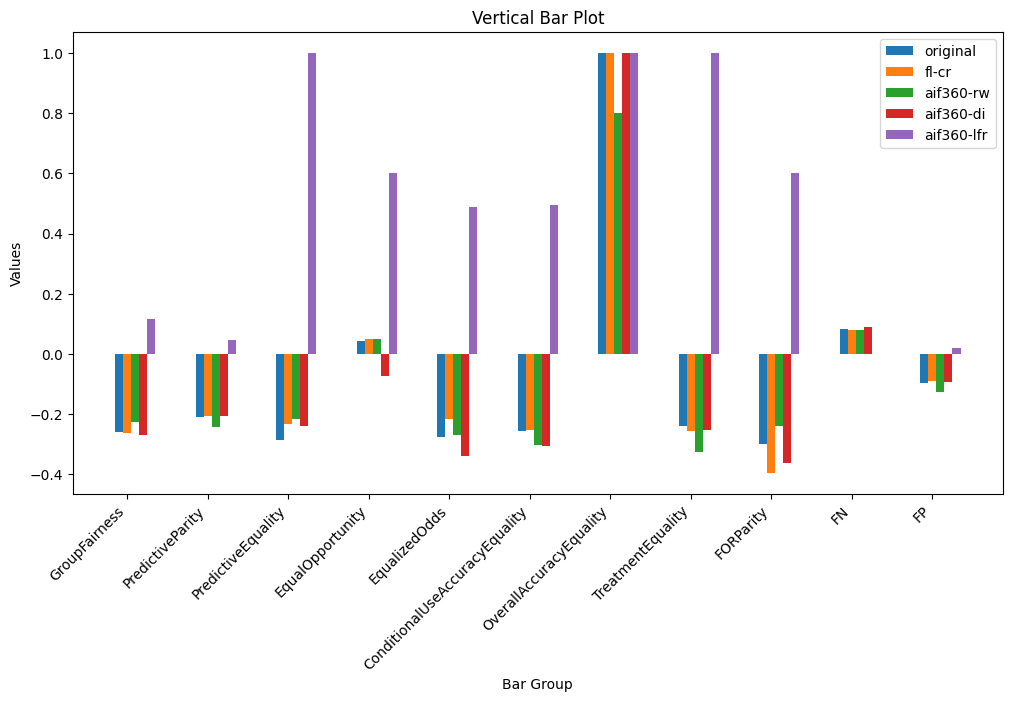

In [30]:
for m in models:
  print(m)
  grouped_bar(preprocessing_metrics["diabetes-women"], preprocessing_mitigation_list, "subtraction", m)


## In-processing results

In [32]:
for m in models:
  inprocessing_mitigation_list.append('orig-'+str(m))

### Diabetes-women, two over three in-processing techniques, division, no ML models

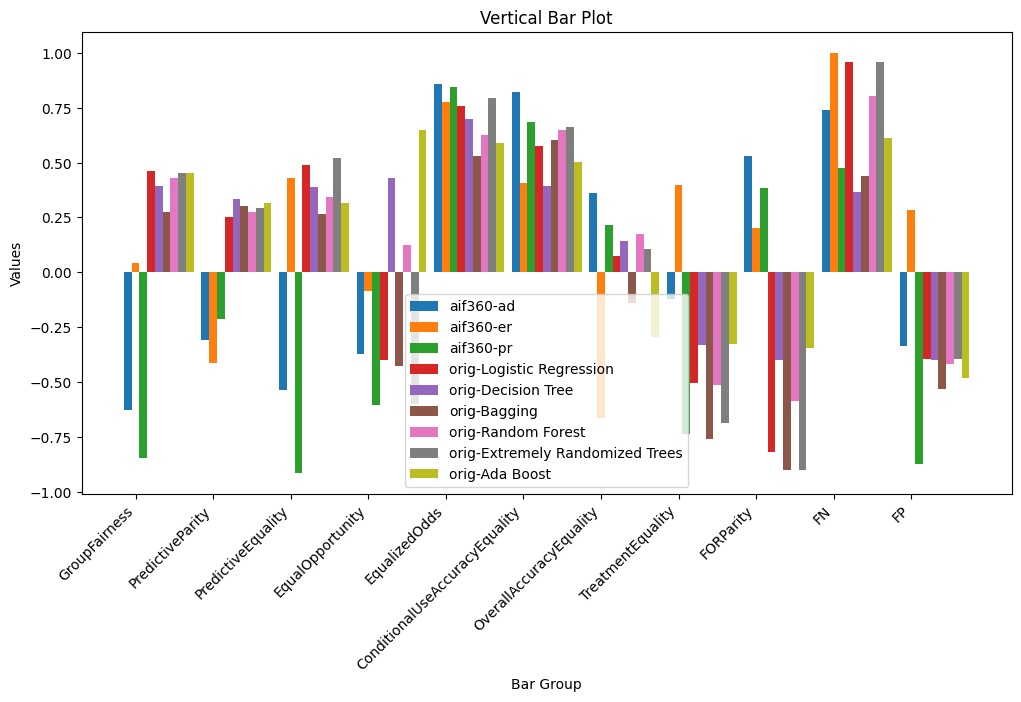

In [33]:
grouped_bar_no_model(inprocessing_metrics["diabetes-women"], inprocessing_mitigation_list, "division")

### Diabetes-women, two over three in-processing techniques, subtraction, no ML models

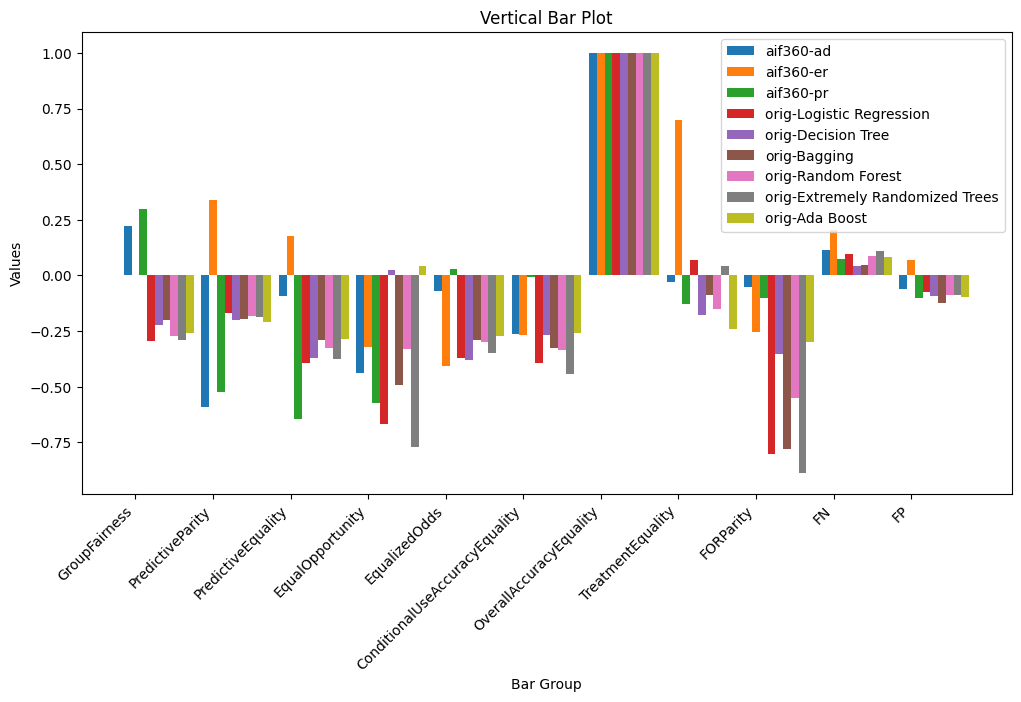

In [34]:
grouped_bar_no_model(inprocessing_metrics["diabetes-women"], inprocessing_mitigation_list, "subtraction")

## Post-processing results

In [35]:
postprocessing_mitigation_list.insert(0,'original')

### Diabetes-women, post-processing techniques, division, ML models

Logistic Regression


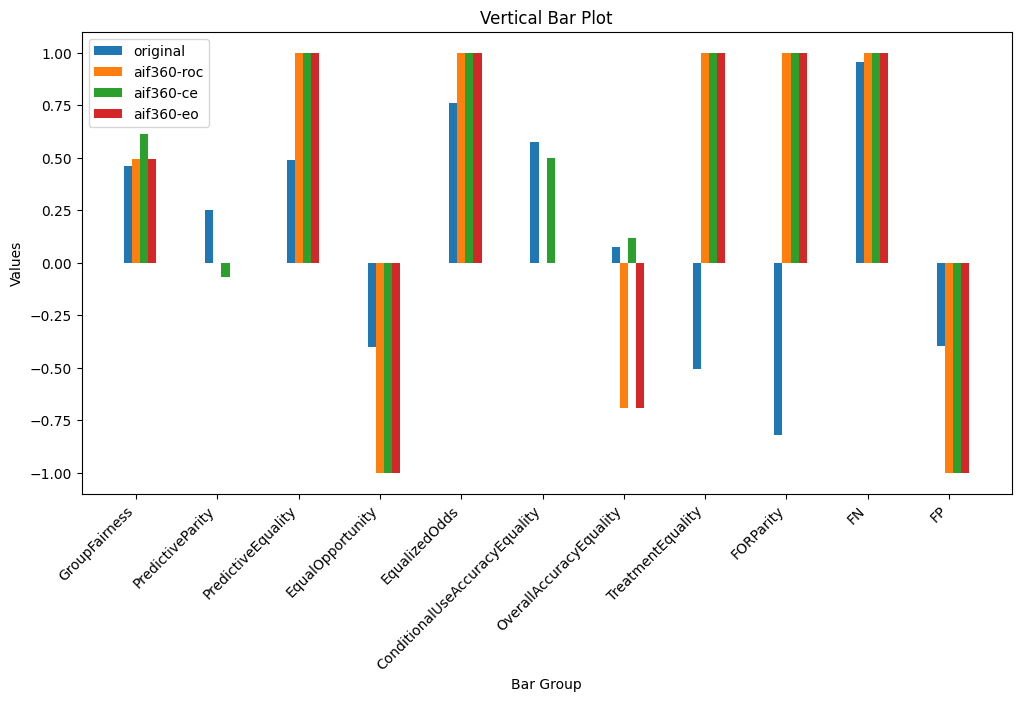

Decision Tree


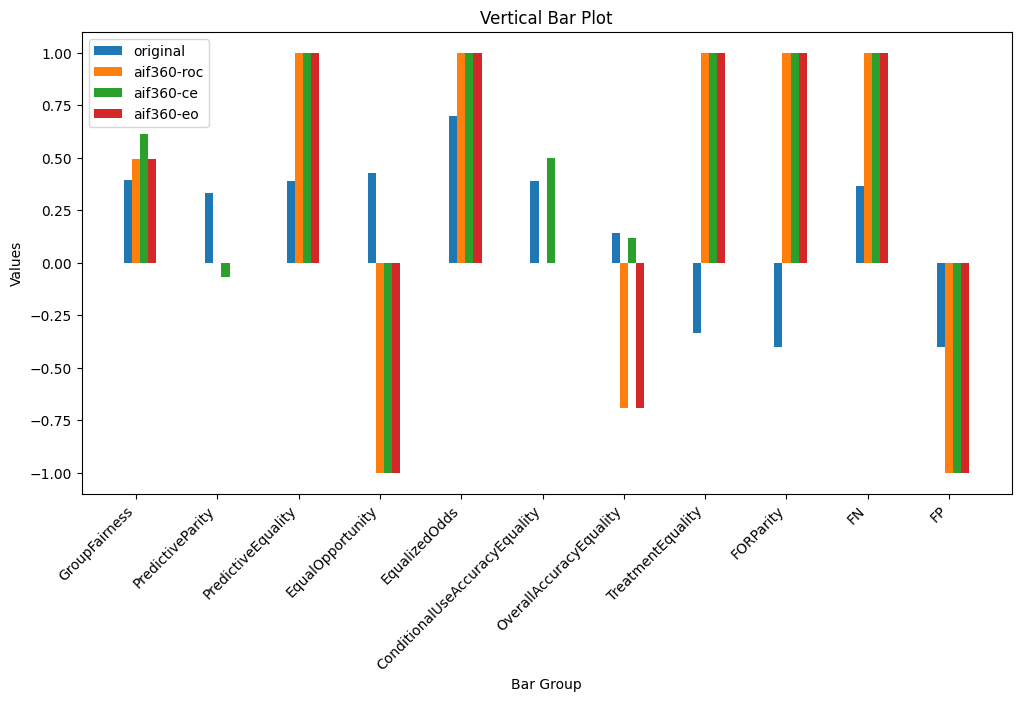

Bagging


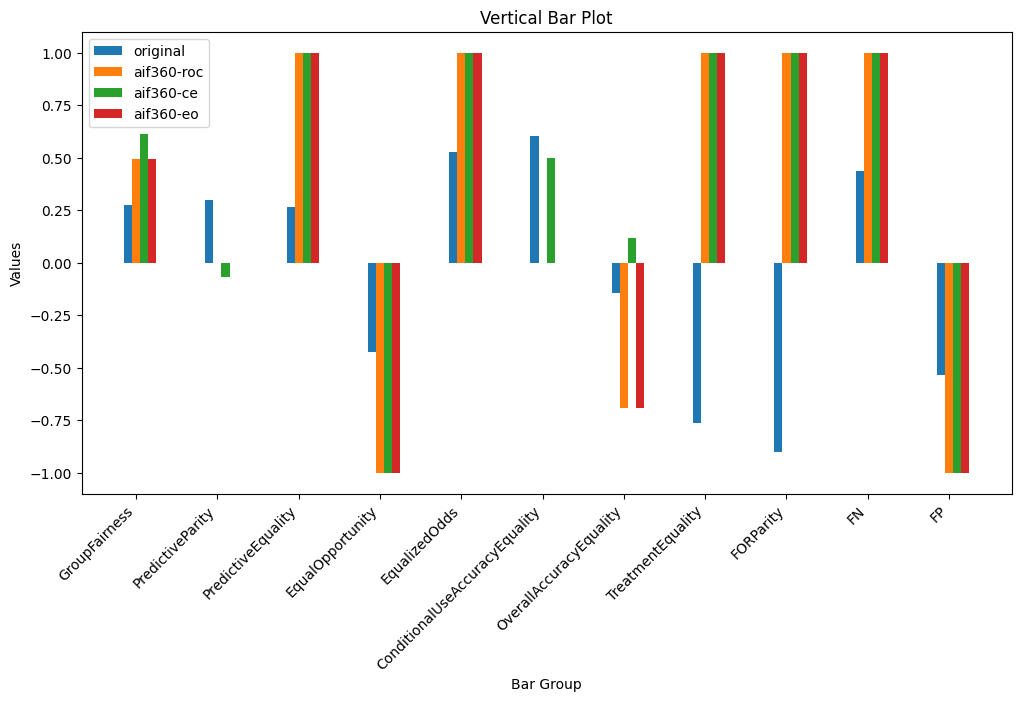

Random Forest


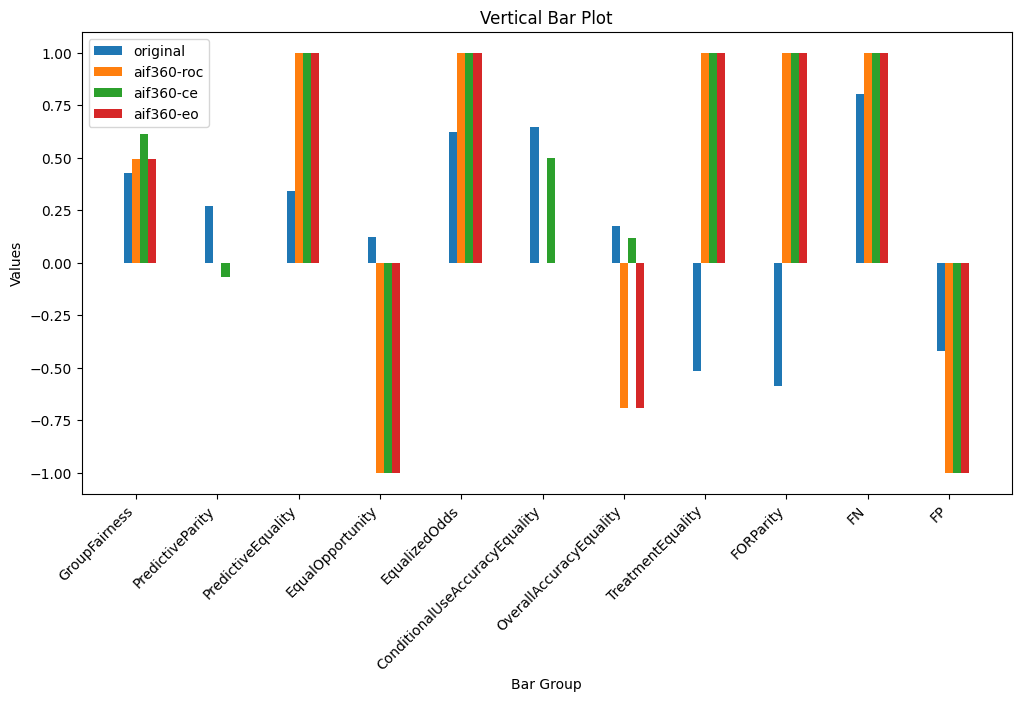

Extremely Randomized Trees


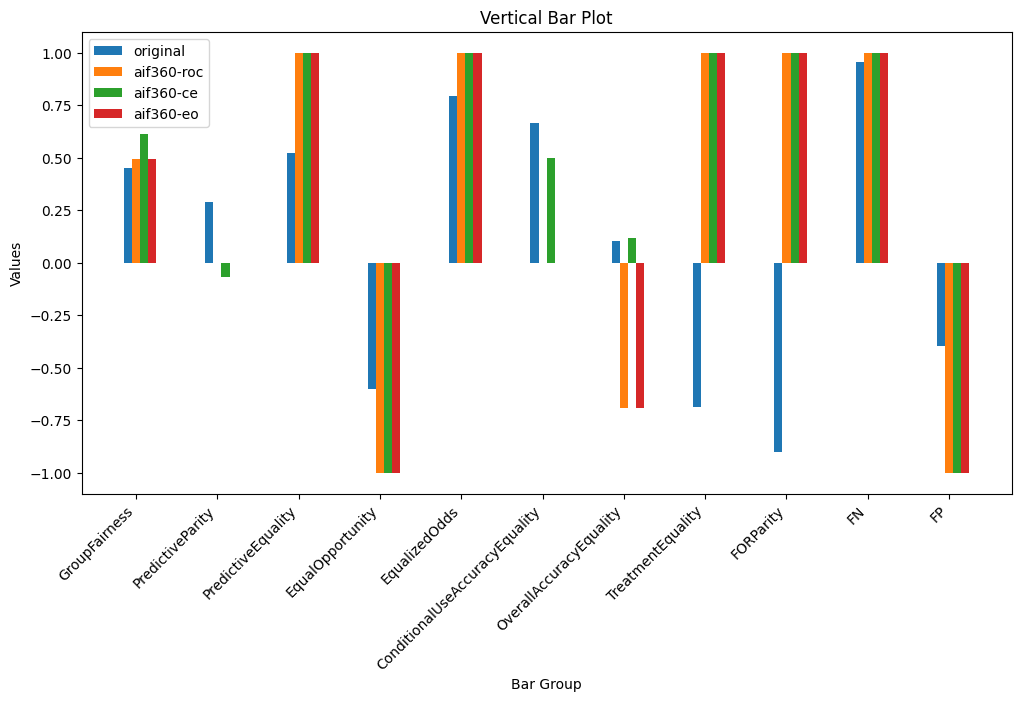

Ada Boost


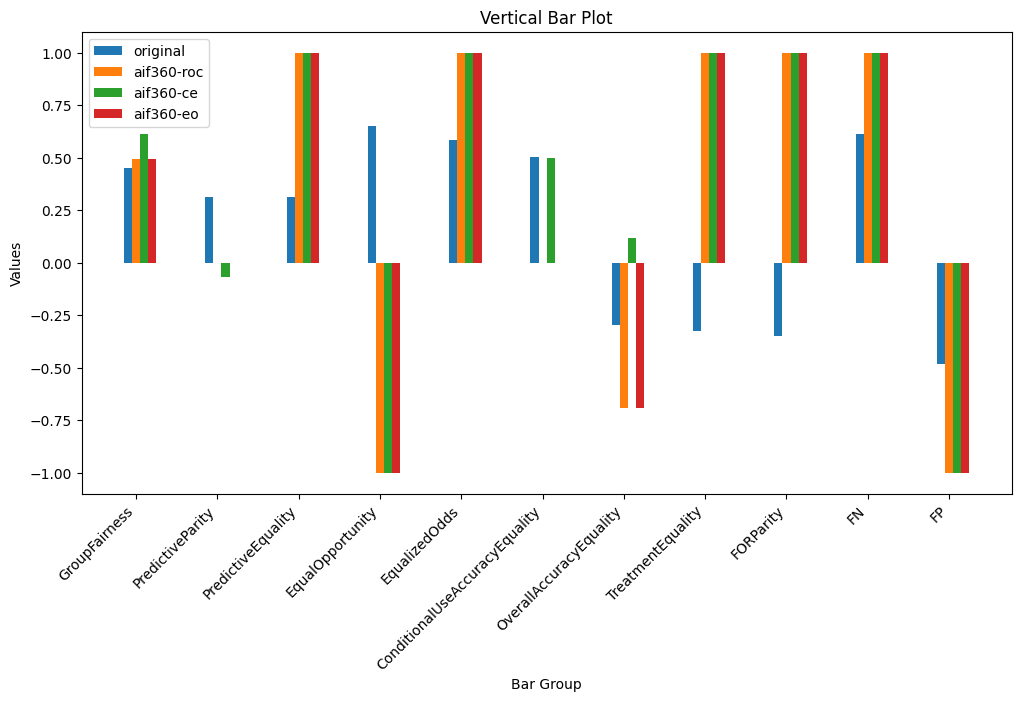

In [36]:
for m in models:
  print(m)
  grouped_bar(postprocessing_metrics["diabetes-women"], postprocessing_mitigation_list, "division", m)

### Diabetes-women, post-processing techniques, subtraction,ML models

Logistic Regression


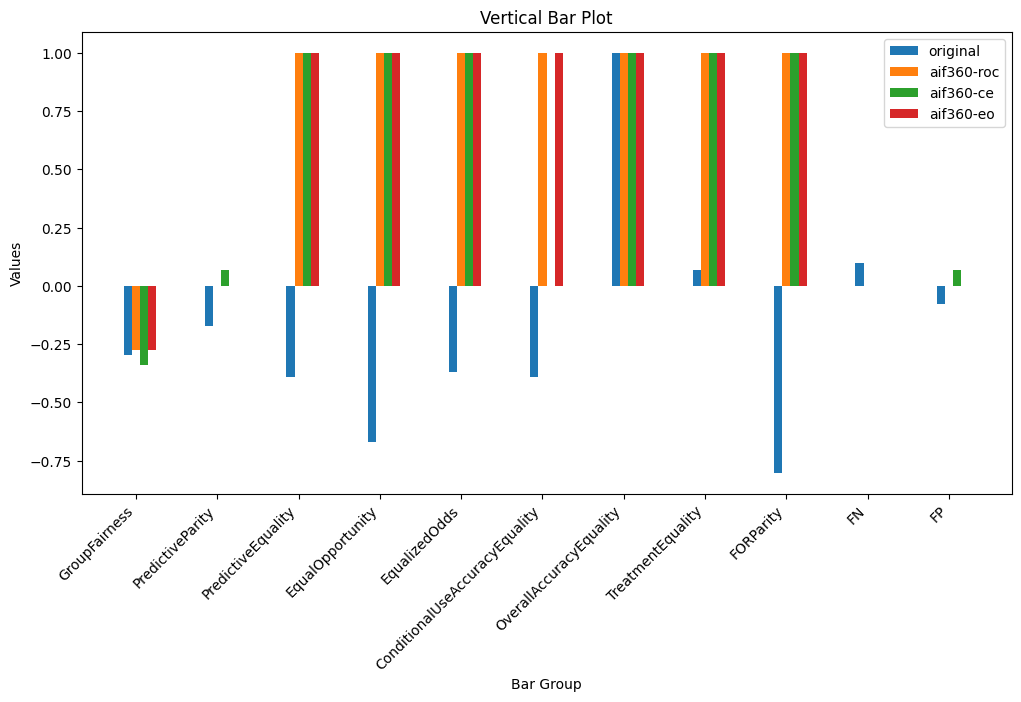

Decision Tree


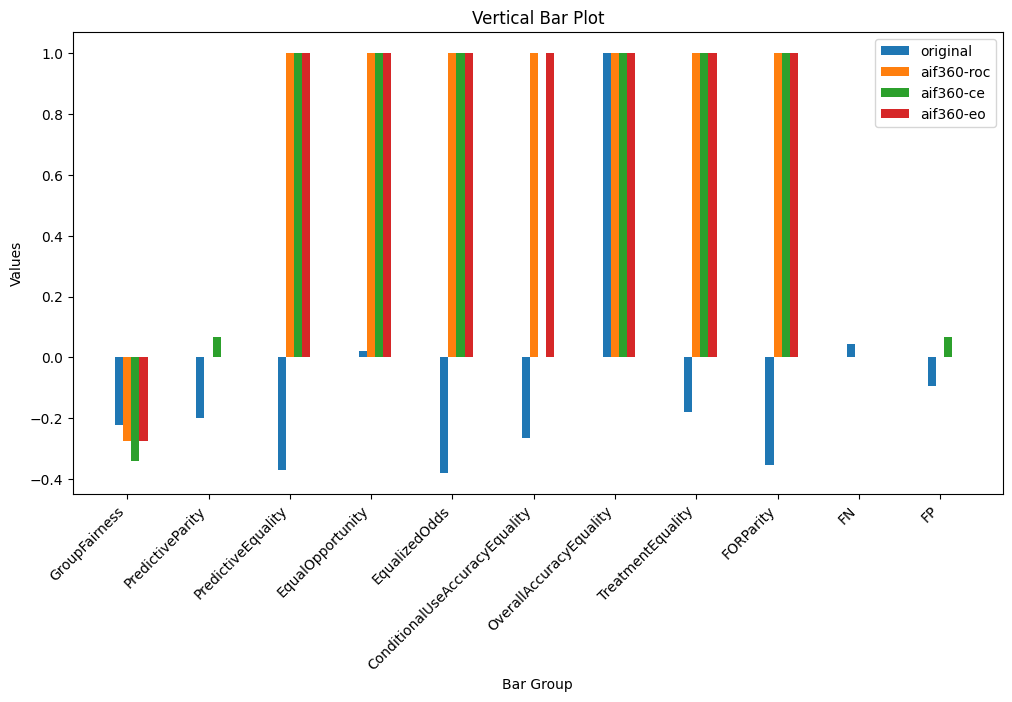

Bagging


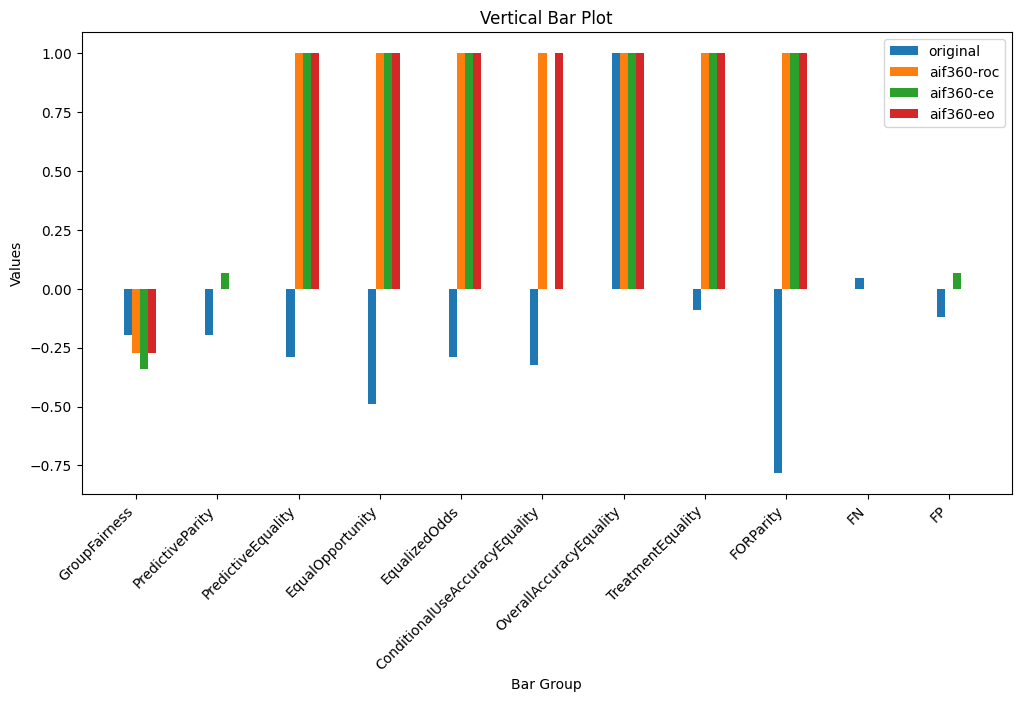

Random Forest


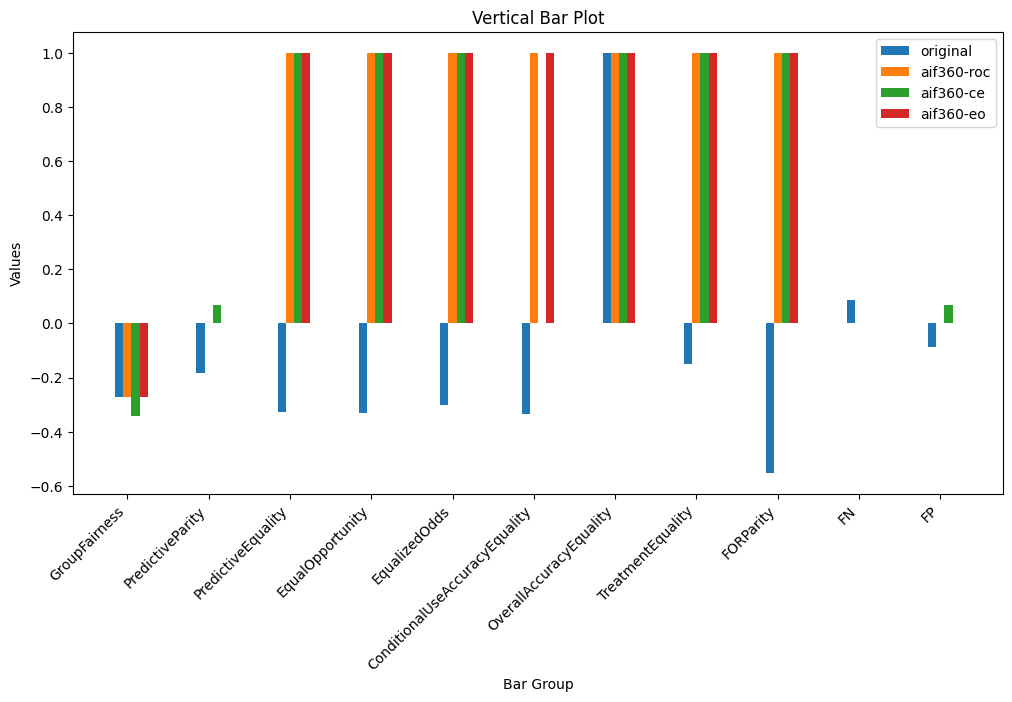

Extremely Randomized Trees


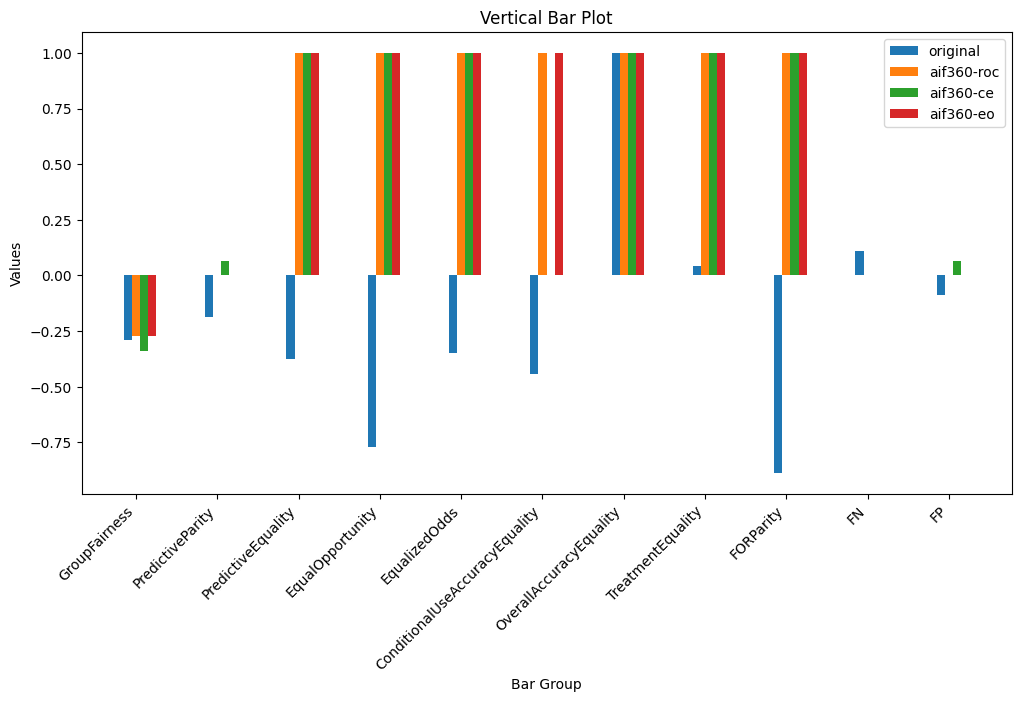

Ada Boost


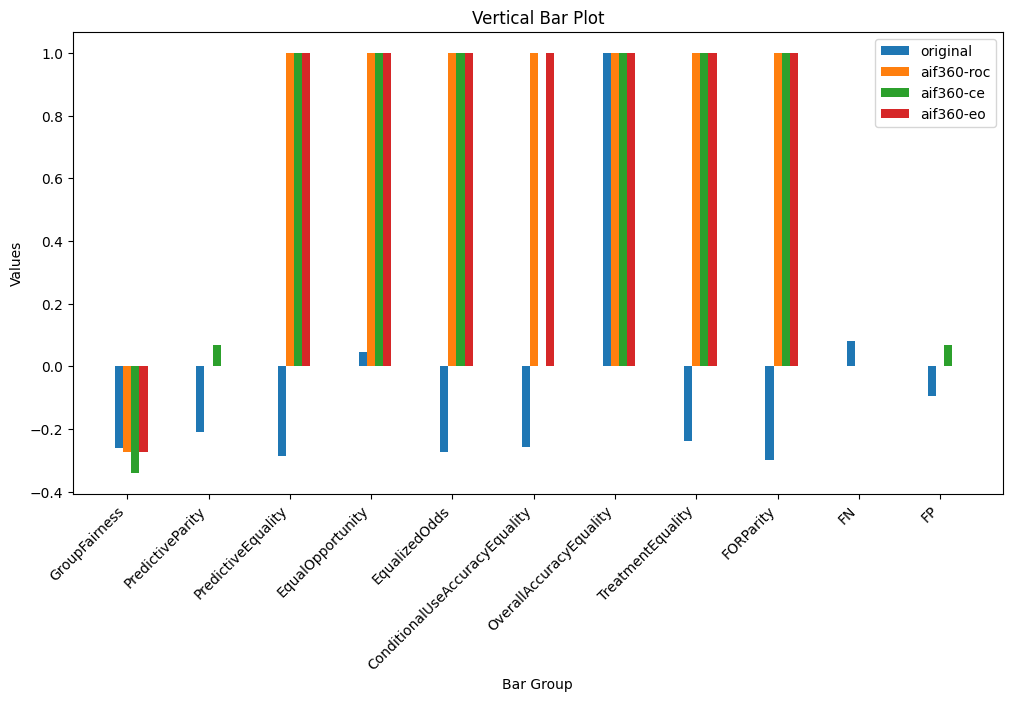

In [37]:
for m in models:
  print(m)
  grouped_bar(postprocessing_metrics["diabetes-women"], postprocessing_mitigation_list, "subtraction", m)

## Other Techniques

### EXTRA
serve che tutte le metriche siano comprese tra due estremi. inoltre sarebbe bello averle centrate sullo zero, per poter fare dei radar plot relativi a ciascuna configurazione e calcolare come valore finale l'area del radar (se è possibile).

altra cosa invece carina è di prendere tutte le metriche insieme e trasformarle in un vettore: con dimenzionality reduction si può mostrare tutti gli algoritmi su un unico grafico, però bisogna stare attenti a cosa mostriamo se facciamo riduzione dei vettori a due sole dimenzioni (es. cosa significa se ci troviamo nel quadrante in alto a destra o in quello in basso a sinistra?). però una cosa interessante è vedere come i diversi algoritmi sono in relazioni tra di loro, quindi una valutazione più qualitativa che quantitativa...

altra idea: se calcolassimo una componente su un asse o su una direzione? però chissà cosa scegliere...

In [42]:
# From a dictionary input, return a bidimensional np.array
def vectorise(dictionary, dataset, comparison, model):
  vector_l = []
  for mitigation in mitigation_list:
    l = []
    for metric in metrics:
      if mitigation in without_model_mitigations:
        l.append(dictionary[dataset][mitigation][comparison][metric][0])
      else:
        l.append(dictionary[dataset][mitigation][comparison][model][metric][0])
    vector_l.append(l)

  vector = np.asarray(vector_l)
  return vector

In [43]:
print(overall_metrics)

{'diabetes-women': {'original': {'division': {'Logistic Regression': {'GroupFairness': [0.4605894995402635, 0.10502607675284904], 'PredictiveParity': [0.251475751585726, 0.174337021259137], 'PredictiveEquality': [0.4883333333333333, 0.645776640283467], 'EqualOpportunity': [-0.4, 0.9165151389911679], 'EqualizedOdds': [0.7602941176470589, 0.2765177593065715], 'ConditionalUseAccuracyEquality': [0.5760102707749767, 0.32612463799177477], 'OverallAccuracyEquality': [0.07500466853408032, 0.7882690880608982], 'TreatmentEquality': [-0.5066666666666666, 0.7683749084919419], 'FORParity': [-0.8206349206349206, 0.34892124003280706], 'FN': [0.9583333333333333, 0.125], 'FP': [-0.396570901412686, 0.3580614036930156]}, 'Decision Tree': {'GroupFairness': [0.3945743513655189, 0.11291241757906456], 'PredictiveParity': [0.3350669959397205, 0.282990911831655], 'PredictiveEquality': [0.3894444444444444, 0.6545305074518568], 'EqualOpportunity': [0.43047619047619046, 0.6755215923778509], 'EqualizedOdds': [0.69

In [46]:
vectorise(overall_metrics, 'diabetes-women', "division", "Logistic Regression")

array([[ 0.4605895 ,  0.25147575,  0.48833333, -0.4       ,  0.76029412,
         0.57601027,  0.07500467, -0.50666667, -0.82063492,  0.95833333,
        -0.3965709 ],
       [ 0.47873061,  0.31323888,  0.39054383,  0.57350132,  0.57949273,
         0.65521611,  0.20653083, -0.28524531, -0.40140097,  0.4496164 ,
        -0.41251703],
       [-0.13914122,  0.32483836, -0.36277778, -0.36247154,  0.39616959,
         0.19775656, -0.74404762, -0.86484788, -0.47807393, -0.55947115,
        -0.72590226],
       [ 0.37548342,  0.37868574,  0.16252315,  0.67103896,  0.5192381 ,
         0.55429208,  0.05984848, -0.28611111, -0.2338404 ,  0.66850291,
        -0.61734067],
       [ 0.46451653,  0.31371357,  0.44952261,  0.45      ,  0.6195705 ,
         0.51813292,  0.04738761, -0.36138047, -0.3726206 ,  0.616579  ,
        -0.48952379],
       [-0.2051447 , -0.04484848,  1.        , -0.8       ,  1.        ,
        -0.03008658, -0.58530952,  1.        ,  0.6       ,  0.8       ,
        -1.   

Transform dictionary into a dataframe.

In [47]:
def data_framing(dictionary, dataset, comparison, model):
  # Define the columns for your DataFrame
  columns = ['Mitigation'] + metrics

  # Create an empty DataFrame with the specified columns
  data = pd.DataFrame(columns=columns)

  for mitigation in mitigation_list:
    l = []
    l.append(mitigation)
    for metric in metrics:
      if mitigation in without_model_mitigations:
        l.append(dictionary[dataset][mitigation][comparison][metric][0])
      else:
        l.append(dictionary[dataset][mitigation][comparison][model][metric][0])
    row_df = pd.DataFrame([l], columns=columns)
    data = pd.concat([data, row_df], ignore_index=True)

  data.set_index('Mitigation', inplace=True)
  return data

In [48]:
data_framing(overall_metrics, 'diabetes-women', "division", "Logistic Regression")

<ipython-input-47-62dc3a731882>:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, row_df], ignore_index=True)


,GroupFairness,PredictiveParity,PredictiveEquality,EqualOpportunity,EqualizedOdds,ConditionalUseAccuracyEquality,OverallAccuracyEquality,TreatmentEquality,FORParity,FN,FP
Mitigation,,,,,,,,,,,
original,0.460589,0.251476,0.488333,-0.400000,0.760294,0.576010,0.075005,-0.506667,-0.820635,0.958333,-0.396571
fl-cr,0.478731,0.313239,0.390544,0.573501,0.579493,0.655216,0.206531,-0.285245,-0.401401,0.449616,-0.412517
fl-to,-0.139141,0.324838,-0.362778,-0.362472,0.396170,0.197757,-0.744048,-0.864848,-0.478074,-0.559471,-0.725902
aif360-rw,0.375483,0.378686,0.162523,0.671039,0.519238,0.554292,0.059848,-0.286111,-0.233840,0.668503,-0.617341
aif360-di,0.464517,0.313714,0.449523,0.450000,0.619571,0.518133,0.047388,-0.361380,-0.372621,0.616579,-0.489524
aif360-lfr,-0.205145,-0.044848,1.000000,-0.800000,1.000000,-0.030087,-0.585310,1.000000,0.600000,0.800000,-1.000000
aif360-op,0.172149,-0.023579,0.277778,0.254959,0.537582,0.021555,-0.574621,0.201667,0.092757,0.240098,0.132125
aif360-ad,-0.626461,-0.310696,-0.538027,-0.372143,0.858791,0.823182,0.359888,-0.119444,0.531275,0.739176,-0.337621
aif360-pr,-0.845003,-0.214643,-0.914812,-0.605675,0.847143,0.684843,0.216888,-0.736905,0.383274,0.476140,-0.875507


### PCA alternative plot, with baseline evidenced.

Distance between fl-cr and original: 0.03396420424596163
Distance between fl-to and original: 21.05935317188484
Distance between aif360-rw and original: 4.431185358604467
Distance between aif360-di and original: 0.3086045868864181


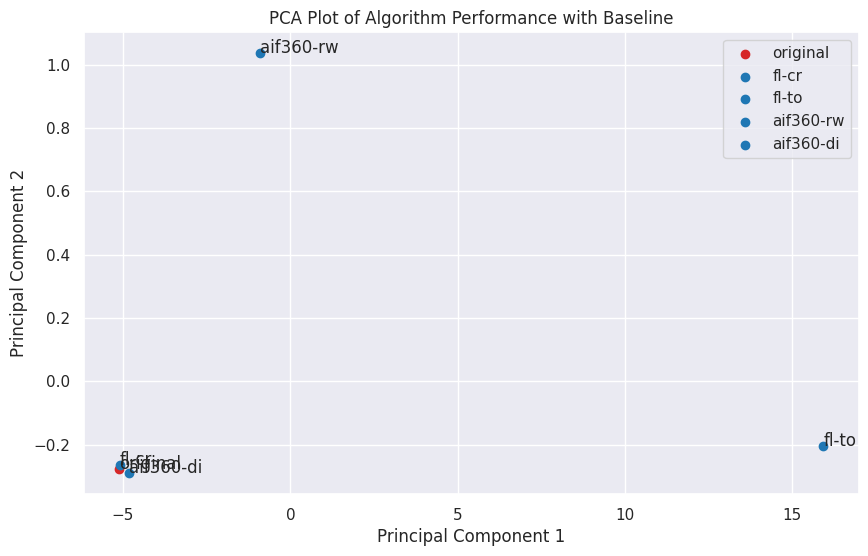

In [ ]:
# Load the data
data = data_framing(overall_metrics, 'diabetes-women', "division", "Logistic Regression")

pca = PCA(n_components=2)
principal_components = pca.fit_transform(data)

# Select a baseline
baseline_algorithm = 'original'
baseline_index = data.index.get_loc(baseline_algorithm)

# Create a scatter plot
plt.figure(figsize=(10, 6))

for i, algorithm in enumerate(data.index):
    if algorithm == baseline_algorithm:
        plt.scatter(principal_components[i, 0], principal_components[i, 1], c='tab:red', label=algorithm)
    else:
        plt.scatter(principal_components[i, 0], principal_components[i, 1], c='tab:blue', label=algorithm)

# Annotate points with names
for i, algorithm in enumerate(data.index):
    plt.annotate(algorithm, (principal_components[i, 0], principal_components[i, 1]))

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot of Algorithm Performance with Baseline')

# Add legend
plt.legend()

# TO DO: Distances should be calculated before the PCA
for i, algorithm in enumerate(data.index):
    if algorithm != baseline_algorithm:
        distance = euclidean(principal_components[i], principal_components[baseline_index])
        print(f"Distance between {algorithm} and {baseline_algorithm}: {distance}")

plt.show()

T-SNE experiment alternative to PCA.

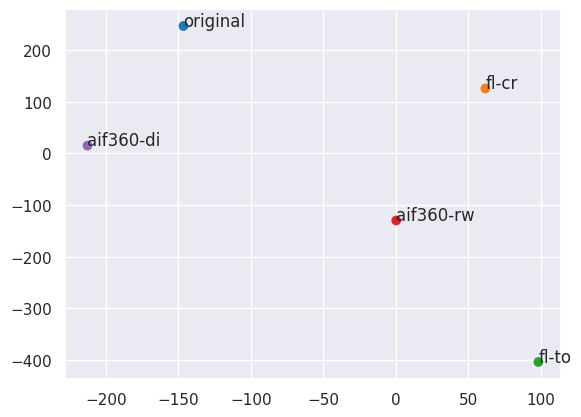

In [ ]:
tsne = TSNE(n_components=2, perplexity=3)
X_r = tsne.fit_transform(vectorise(overall_metrics, 'diabetes-women', "division", "Logistic Regression"))

fig = plt.figure()
ax = fig.add_subplot(111)
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']#,'tab:cyan']
ax.scatter(X_r[:, 0], X_r[:, 1], color=colors)
for i, label in enumerate(mitigation_list):
    plt.annotate(label, (X_r[:, 0][i], X_r[:, 1][i]))
plt.show()

PCA plot with vectors of metrics.

In [ ]:
# pca = PCA(n_components=2)
# X_r = pca.fit_transform(vectorise(overall_metrics, 'diabetes-women', "division", "Logistic Regression"))

# fig = plt.figure()
# ax = fig.add_subplot(111)
# colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:cyan']
# ax.scatter(X_r[:, 0], X_r[:, 1], color=colors)
# for i, label in enumerate(models):
#     plt.annotate(label, (X_r[:, 0][i], X_r[:, 1][i]))
# plt.show()

### Heatmaps

In [ ]:
# Aggregation of metrics
def aggregate_all(metrics_dictionary, dataset, mitigation, comparison, model):
  l = []
  for metric in metrics:
    l.append(metrics_dictionary[dataset][mitigation][comparison][model][metric]["Value"])
  return np.mean(l), np.std(l)

In [ ]:
# TO DO questo richiede chiaramente che le misure vengano in qualche modo normalizzate o stiano tutte entro lo stesso intervallo e con significati quantitativi simili -> DIFFICILE
aggregate_all(overall_metrics, 'diabetes-women', 'original', "division", "Logistic Regression")

(0.773040075484052, 0.8233747180135076)

In [ ]:
# Aggregation of metrics by family
def fine_aggregation(metrics_dictionary, dataset, mitigation, comparison, model):
  groups = {'metrics_on_results': ['GroupFairness'],
            'metrics_on_FP': ['PredictiveParity', 'PredictiveEquality', 'FP'],
            'metrics_on_FN': ['EqualOpportunity', 'FORParity', 'FN'],
            'metrics_on_all': ['TreatmentEquality', 'EqualizedOdds', 'ConditionalUseAccuracyEquality', 'OverallAccuracyEquality']
            }

  aggregated_metrics = {}
  for k in groups.keys():
    support = []
    for metric in groups[k]:
      support.append(metrics_dictionary[dataset][mitigation][comparison][model][metric]["Value"])
    aggregated_metrics[k] = np.array([np.mean(support), np.std(support)])

  return aggregated_metrics

In [ ]:
fine_aggregation(overall_metrics, 'diabetes-women', 'original', "division", "Logistic Regression")

{'metrics_on_results': array([0.16663068, 0.        ]),
 'metrics_on_FP': array([0.45187236, 0.51140587]),
 'metrics_on_FN': array([1.6692151, 0.8035506]),
 'metrics_on_all': array([0.49338694, 0.57799776])}

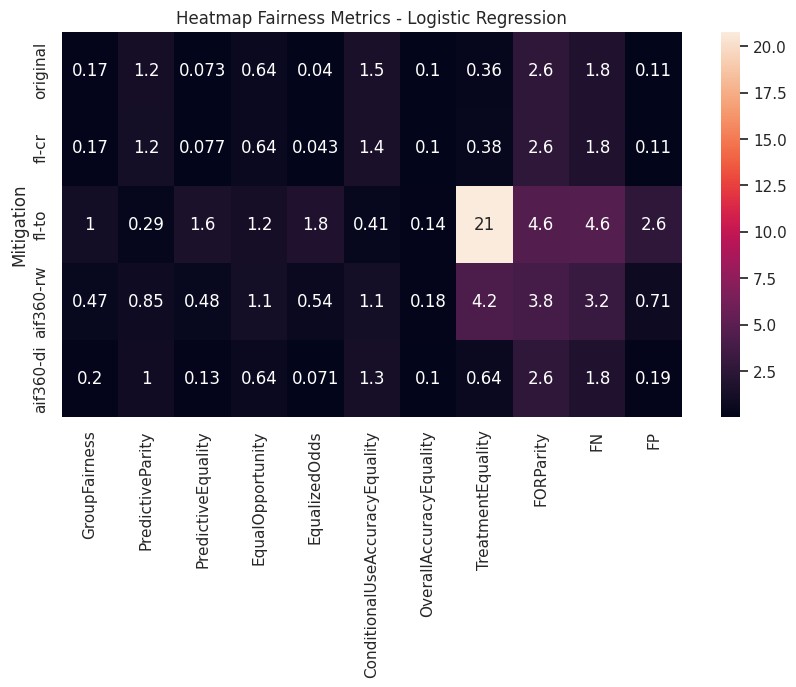

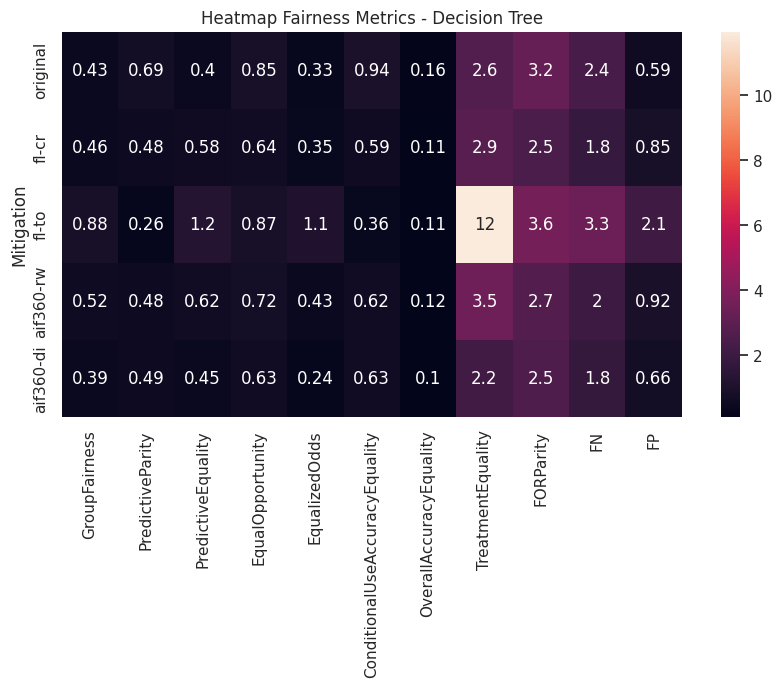

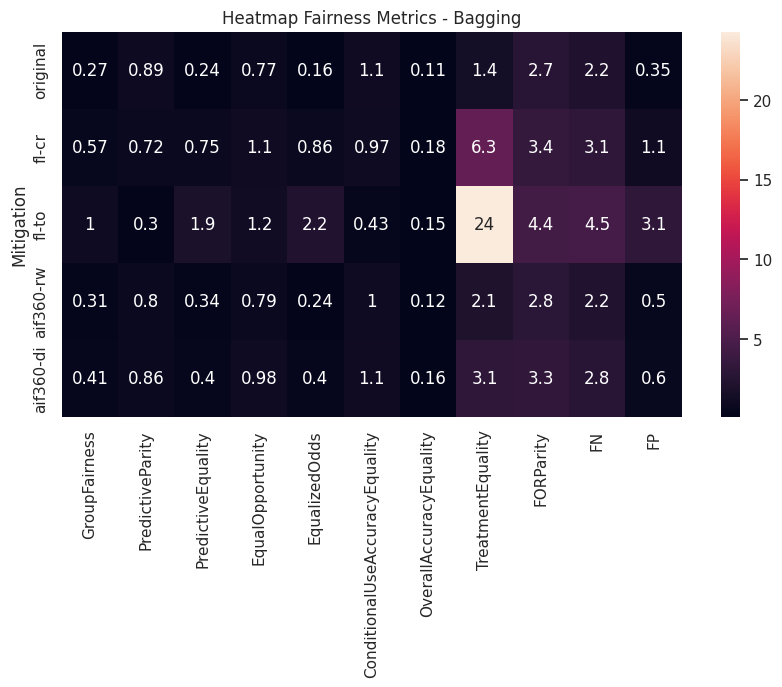

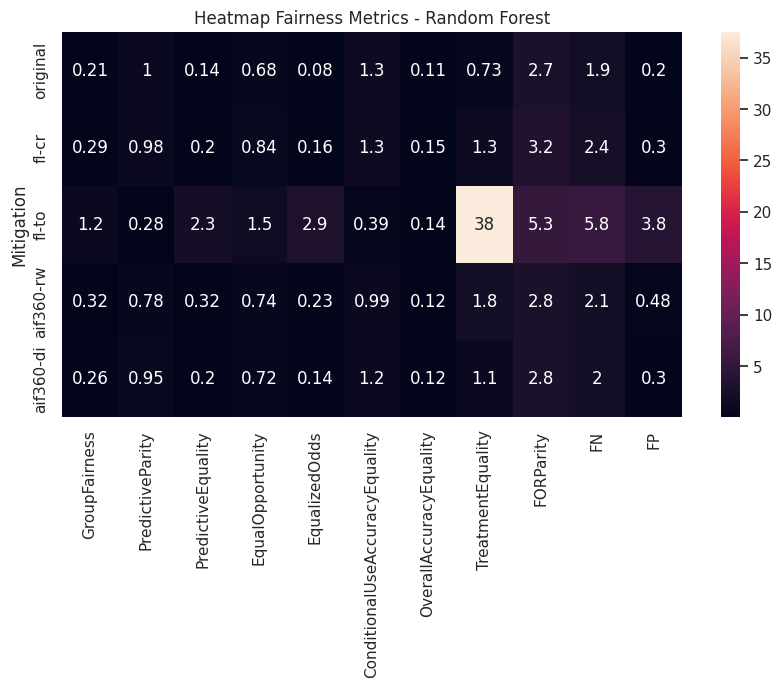

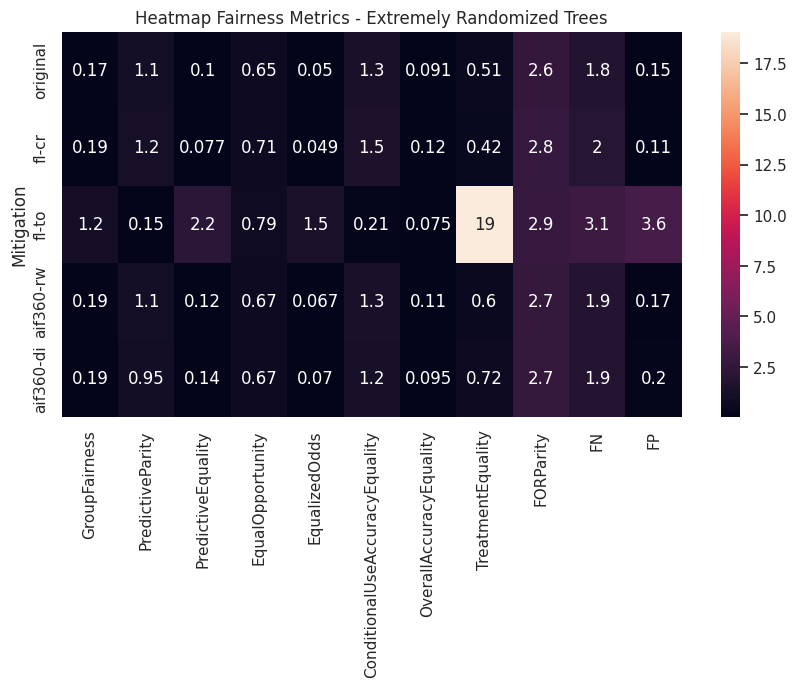

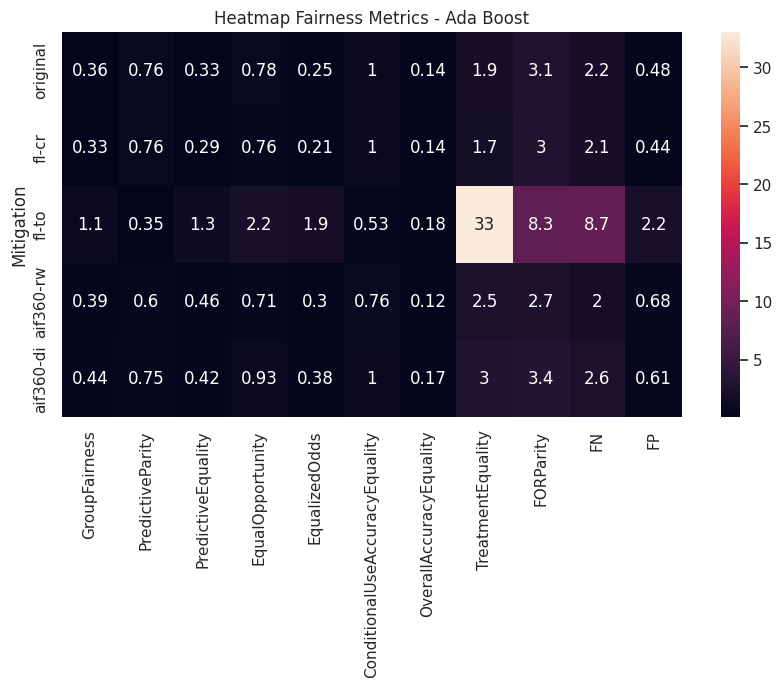

In [ ]:
sns.set()
for model in models:
  plt.figure(figsize=(10, 5))
  ax = sns.heatmap(data_framing(overall_metrics, 'diabetes-women', "division", model), annot=True)
  plt.title("Heatmap Fairness Metrics - {}".format(model))
  plt.show()